# Preparación de entorno

In [1]:
!rm -rf ~/.cache/huggingface
!pip install -q --upgrade datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 27.7 MB/s eta 0:00:00


In [2]:
!pip install fsspec==2023.9.2
!pip install rouge-score

In [3]:
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
import pickle

from tensorflow.keras.models import load_model
from datasets import load_dataset
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from tqdm import tqdm

# Descarga de modelos

In [4]:
links = [
    ("model_cnn_max.keras", "https://raw.githubusercontent.com/JuanZweifel/deep-learning-2025/main/Modelos_ET/model_ccn_max.keras"),
    ("modelo_lstm.keras", "https://raw.githubusercontent.com/JuanZweifel/deep-learning-2025/main/Modelos_ET/LSTM.keras"),
    ("diccionarios.pkl", "https://raw.githubusercontent.com/JuanZweifel/deep-learning-2025/main/Modelos_ET/diccionarios.pkl"),
    ("modelo_transformer.keras", "https://www.dropbox.com/scl/fi/6gdjcku955k94fto6g5xa/Transformer.keras?rlkey=txqyw577qwxn98dp1rojdbhrm&st=o4c7xwnv&dl=1")
]

for filename, url in links:
    if not os.path.exists(filename):
        print(f"Descargando {filename}...")
        !wget "{url}" -O "{filename}"
    else:
        print(f"{filename} ya existe. No se descarga.")

model_cnn_max.keras ya existe. No se descarga.
modelo_lstm.keras ya existe. No se descarga.
diccionarios.pkl ya existe. No se descarga.
modelo_transformer.keras ya existe. No se descarga.


# CNN (Simpson)

In [5]:
def load_test_set(dirname : str, map_characters : np.array, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)

In [6]:
!wget -q -O simpsons_test.tar.gz https://www.dropbox.com/scl/fi/zche5dm3zgd9jysatnmka/simpsons_test.tar.gz?rlkey=iek183gc4t4w9mdnz1izhudni&st=qau98qns&dl=0
!tar -xzf simpsons_test.tar.gz

In [7]:
model_cnn_max = load_model('model_cnn_max.keras')

In [8]:
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel',
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson',
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak',
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Se estandarizan todas las imágenes a tamaño 64x64
IMG_SIZE = 64

In [9]:
# Carga los datos
DATASET_TEST_PATH_COLAB = "simpsons_testset"

X_test, y_test = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)
X_test = X_test.astype("float32") / 255.0
y_test = to_categorical(y_test, num_classes=len(MAP_CHARACTERS))

Leídas 890 imágenes de test


In [10]:
loss, accuracy = model_cnn_max.evaluate(X_test, y_test)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

y_pred_probs = model_cnn_max.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

target_names = [MAP_CHARACTERS[i] for i in sorted(MAP_CHARACTERS.keys())]

report_cnn_max = classification_report(y_true, y_pred, target_names=target_names)
print(report_cnn_max)

28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.9717 - loss: 0.1087
Test Loss: 0.08845086395740509
Test Accuracy: 0.9775280952453613
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.94      0.92      0.93        48
  apu_nahasapeemapetilon       1.00      1.00      1.00        50
            bart_simpson       0.94      0.88      0.91        50
charles_montgomery_burns       0.92      1.00      0.96        48
            chief_wiggum       1.00      1.00      1.00        50
          comic_book_guy       1.00      1.00      1.00        49
          edna_krabappel       1.00      0.98      0.99        50
           homer_simpson       0.91      0.98      0.94        50
           kent_brockman       0.98      0.96      0.97        50
        krusty_the_clown       1.00      1.00      1.00        50
            lisa_simpson       1.00      0.94      0.97        50
           marge_simpson    

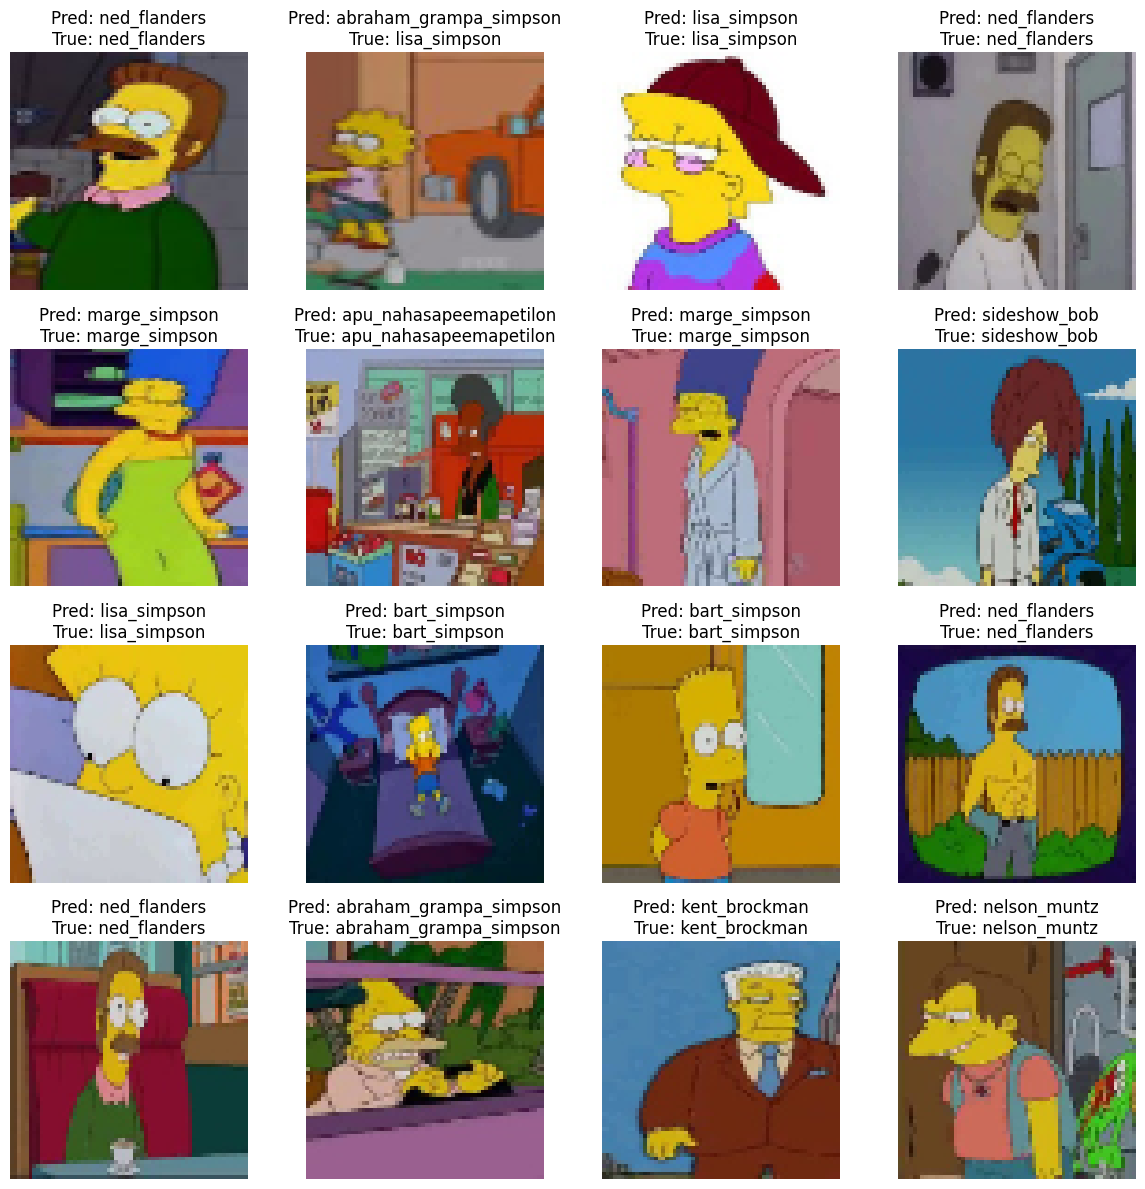

In [11]:
num_images = 16
plt.figure(figsize=(12, 12))

for i in range(num_images):
    plt.subplot(4, 4, i + 1)
    plt.imshow(X_test[i])
    true_label = MAP_CHARACTERS[y_true[i]]
    pred_label = MAP_CHARACTERS[y_pred[i]]
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()

# RNN/LSTM (Don quijote)


Carga del diccionario

In [12]:
# Cargar (en celda distinta o después)
with open("diccionarios.pkl", "rb") as f:
    diccionarios = pickle.load(f)

char_to_idx = diccionarios["char_to_idx"]
idx_to_char = diccionarios["idx_to_char"]

Carga del modelo LSTM

In [13]:
# Cargar modelo
modelo_lstm = load_model("modelo_lstm.keras")

Funcion para generar texto

In [14]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + 1e-10) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def generate_text_emb(seed_text, model, length, temperature=1.0):
    generated = seed_text
    sentence = seed_text

    for _ in range(length):
        x_pred = np.zeros((1, SEQ_LENGTH), dtype=np.int32)
        for t, char in enumerate(sentence):
            if char in char_to_idx:
                x_pred[0, t] = char_to_idx[char]
            else:
                x_pred[0, t] = 0

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = idx_to_char[next_index]

        generated += next_char
        sentence = sentence[1:] + next_char

    return generated

Generación del texto

In [15]:
seed_text = "o le cautivaron y rindieron el"
temperaturas = [0.2, 0.5, 0.8]
longitud_generada = 300
SEQ_LENGTH = 30

for temp in temperaturas:
    print(f"\n--- Generación con temperatura: {temp} ---")
    texto_generado_emb = generate_text_emb(seed_text, modelo_lstm, longitud_generada, temperature=temp)
    print("Texto generado:\n", texto_generado_emb)


--- Generación con temperatura: 0.2 ---
Texto generado:
 o le cautivaron y rindieron el camino de la mano a su amo de la cabeza, y que en la cabeza a la verdad de la carta de la mano a la silla, y a la cabeza de la calidad de la mano a la casa de la señora dulcinea del toboso, y a la cabeza y con quien en el mundo que le había de hacer en la cabeza de la duquesa, y no hay mala alguna 

--- Generación con temperatura: 0.5 ---
Texto generado:
 o le cautivaron y rindieron el deseo contra su marcela del caballero de sus mundos y de poco: los dos andantes los que el cual se llama de la señora dijo:

-no quiso ser muy baje del camino de la hijo del alabando de aquellos deseos y compuestas que alguna perdice de las cuales se encaminas a la duquesa en la carta
de la tierra 

--- Generación con temperatura: 0.8 ---
Texto generado:
 o le cautivaron y rindieron el mesmo le olvididaban contentos de verdaderos que le había hecho. no más venturas todos los
versos de barbero, a lo dicen que me viene

# Transformer (Daily-dialog)

## Funciones

In [16]:
def decode_sequence(input_text, tokenizer, model, max_len=280):
    # Tokenizar y pad la entrada
    # print("Tokens entrada:", tokenizer.texts_to_sequences([input_text])[0])
    input_seq = tokenizer.texts_to_sequences([input_text])
    input_seq = pad_sequences(input_seq, maxlen=max_len, padding='post')

    # Inicializamos decoder con solo el token <start>
    decoder_input = [tokenizer.word_index['<start>']]
    output = []

    for _ in range(max_len):

        # Pad y reshape el input del decoder
        decoder_input_seq = pad_sequences([decoder_input], maxlen=max_len, padding='post')

        # Predecimos el siguiente token
        predictions = model.predict([input_seq, decoder_input_seq], verbose=0)
        predicted_id = np.argmax(predictions[0, len(decoder_input)-1])

        # Si predijo <end>, detenemos
        if predicted_id == tokenizer.word_index['<end>']:
            break

        output.append(predicted_id)
        decoder_input.append(predicted_id)
        # print("Predicted ID:", predicted_id, "→", tokenizer.index_word.get(predicted_id, '?'))

    # Convertimos los IDs a texto
    decoded_words = [tokenizer.index_word.get(id, '') for id in output]
    return ' '.join(decoded_words)

## Datos

In [17]:
# Cargar el dataset DailyDialog
dataset = load_dataset("daily_dialog", download_mode="force_redownload")

# Dividir en entrenamiento y prueba
train_data, test_data, validation_data = dataset['train'], dataset['test'], dataset['validation']

train_inputs, train_targets = [], []
val_inputs, val_targets = [], []
test_inputs, test_targets = [], []

def procesar_dataset(dataset_split, input_list, target_list):
    for ejemplo in dataset_split:
        oraciones = ejemplo['dialog']
        for i in range(len(oraciones) - 1):
            entrada = oraciones[i].strip()
            respuesta = "<start> " + oraciones[i + 1].strip() + " <end>"
            input_list.append(entrada)
            target_list.append(respuesta)

# Aplicar por separado
procesar_dataset(dataset['train'], train_inputs, train_targets)
procesar_dataset(dataset['validation'], val_inputs, val_targets)
procesar_dataset(dataset['test'], test_inputs, test_targets)

print("Ejemplo entrada:", train_inputs[9])
print("Ejemplo respuesta:", train_targets[9])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

daily_dialog.py: 0.00B [00:00, ?B/s]

daily_dialog.py: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

The repository for daily_dialog contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/daily_dialog.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/11118 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Ejemplo entrada: Can you do push-ups ?
Ejemplo respuesta: <start> Of course I can . It's a piece of cake ! Believe it or not , I can do 30 push-ups a minute . <end>


## Tokenizador


In [18]:
# 1. Preparar textos de entrenamiento para ajustar el tokenizer
all_texts = train_inputs + train_targets

# 2. Crear el tokenizer
tokenizer = Tokenizer(filters='', lower=True, oov_token='<OOV>')
tokenizer.fit_on_texts(all_texts)

# 3. Convertir textos a secuencias
def textos_a_tensor(inputs, targets, tokenizer, max_len=None):
    input_seq = tokenizer.texts_to_sequences(inputs)
    target_seq = tokenizer.texts_to_sequences(targets)

    # Padding
    if not max_len:
        max_len = max(max(len(s) for s in input_seq), max(len(s) for s in target_seq))

    input_seq = pad_sequences(input_seq, maxlen=max_len, padding='post')
    target_seq = pad_sequences(target_seq, maxlen=max_len, padding='post')

    return input_seq, target_seq, max_len

# Aplicamos a cada split
train_encoder_in, train_decoder_out, max_len = textos_a_tensor(train_inputs, train_targets, tokenizer)
val_encoder_in, val_decoder_out, _ = textos_a_tensor(val_inputs, val_targets, tokenizer, max_len=max_len)
test_encoder_in, test_decoder_out, _ = textos_a_tensor(test_inputs, test_targets, tokenizer, max_len=max_len)

In [19]:
model_transformer = load_model("modelo_transformer.keras")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'functional' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'functional_1' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [20]:
response = decode_sequence("what do you think", tokenizer, model_transformer, max_len=280)
print("Respuesta del modelo:", response)

Respuesta del modelo: i think i should do it .


## Bleu

In [21]:
# Ejemplo de evaluación del modelo usando BLEU o ROUGE
# predictions = model.predict(test_data)
# print("BLEU Score:", sentence_bleu(reference_sentences, predictions))
smoothie = SmoothingFunction().method4

bleu_scores = []

# Evaluamos, por ejemplo, 100 muestras del conjunto de test
for i in range(20):
    input_text = test_data[i]['dialog'][0]
    reference = test_data[i]['dialog'][1]

    print("Entrada: ", input_text)

    prediction = decode_sequence(input_text, tokenizer, model_transformer, max_len=max_len)
    print("Respuesta: ", prediction)
    print("Referencia: ", reference)
    print("\n")
    ref_tokens = reference.lower().split()
    pred_tokens = prediction.lower().split()

    bleu = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smoothie)
    bleu_scores.append(bleu)

print(f"BLEU promedio en 100 muestras: {np.mean(bleu_scores):.4f}")

Entrada:  Hey man , you wanna buy some weed ? 
Respuesta:  yes , i have a nice girl .
Referencia:   Some what ? 


Entrada:  The taxi drivers are on strike again . 
Respuesta:  then , then , please .
Referencia:   What for ? 


Entrada:  We've managed to reduce our energy consumption in our factory by about 15 per cent in the last two years . 
Respuesta:  are you sure ?
Referencia:   That's excellent . How have you managed that ? 


Entrada:  Believe it or not , tea is the most popular beverage in the world after water . 
Respuesta:  oh , i know what they are very smart .
Referencia:   Well , people from Asia to Europe all enjoy tea . 


Entrada:  What are your personal weaknesses ? 
Respuesta:  i am working hard to do . i am working in my work .
Referencia:   I ’ m afraid I ’ m a poor talker . I ’ m not comfortable talking with the people whom I have just met for the first time . That is not very good for business , so I have been studying public speaking . 


Entrada:  how long will 

## ROUGE

In [22]:
# Evaluación con ROUGE
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge1_scores, rouge2_scores, rougeL_scores = [], [], []

# Usa un subconjunto de test_data para acelerar el proceso si es muy grande
for example in tqdm(test_data.select(range(20))):  # Cambia el rango si quieres evaluar más
    input_text = example['dialog'][0]  # Asume que dialog es una lista [input, response]
    reference_text = example['dialog'][1]  # Ground truth

    generated_text = decode_sequence(input_text, tokenizer, model_transformer)

    scores = scorer.score(reference_text, generated_text)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# Promedios
print("\n")
print(f"ROUGE-1 promedio: {np.mean(rouge1_scores):.4f}")
print(f"ROUGE-2 promedio: {np.mean(rouge2_scores):.4f}")
print(f"ROUGE-L promedio: {np.mean(rougeL_scores):.4f}")

100%|██████████| 20/20 [00:21<00:00,  1.09s/it]



ROUGE-1 promedio: 0.1621
ROUGE-2 promedio: 0.0359
ROUGE-L promedio: 0.1621
